[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NU-MSE-LECTURES/465_Computational_Microscopy_2026/blob/dev/Week_04/code_examples/example_01_supervised_learning.ipynb)

# Example 01: Supervised Learning for Electron Microscopy

## Overview
This notebook demonstrates supervised learning approaches for electron microscopy image analysis:
1. **Particle Classification** - Classify particles by shape/composition using labeled training data
2. **Defect Detection** - Identify crystallographic defects using Random Forest classifier
3. **Phase Segmentation** - Segment multi-phase materials using Support Vector Machines (SVM)
4. **Model Evaluation** - Proper train/test split, cross-validation, and performance metrics

## Learning Objectives
- Understand the supervised learning workflow: labeling → feature extraction → training → validation
- Learn appropriate feature engineering for microscopy images
- Compare classical ML models (Random Forest, SVM, k-NN) for image-based tasks
- Implement proper model evaluation and avoid overfitting
- Apply trained models to unlabeled data for prediction

## Prerequisites
- Week 3: Image processing fundamentals
- Basic understanding of classification concepts
- Familiarity with NumPy and scikit-learn

In [1]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install -q hyperspy scikit-learn scikit-image scipy matplotlib seaborn pandas
    !git clone https://github.com/NU-MSE-LECTURES/465_Computational_Microscopy_2026.git
    import os
    os.chdir('465_Computational_Microscopy_2026/Week_04/code_examples')
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Not running in Google Colab.


In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Image processing
from skimage import filters, morphology, measure, feature, segmentation
from scipy import ndimage

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


---
## Part 1: Synthetic Dataset Generation

We'll create synthetic microscopy data representing different particle types with distinct morphological features.

In [3]:
def create_particle_dataset(n_samples=200, img_size=64):
    """
    Generate synthetic particle images with three classes:
    - Class 0: Circular particles (e.g., Au nanoparticles)
    - Class 1: Elongated particles (e.g., nanorods)
    - Class 2: Irregular particles (e.g., defects or aggregates)
    
    Returns:
        images: Array of shape (n_samples, img_size, img_size)
        labels: Array of class labels (0, 1, or 2)
    """
    images = []
    labels = []
    
    samples_per_class = n_samples // 3
    
    for i in range(n_samples):
        img = np.zeros((img_size, img_size))
        
        # Determine class
        if i < samples_per_class:
            # Class 0: Circular particles
            center_x = np.random.randint(img_size // 4, 3 * img_size // 4)
            center_y = np.random.randint(img_size // 4, 3 * img_size // 4)
            radius = np.random.randint(8, 15)
            
            Y, X = np.ogrid[:img_size, :img_size]
            mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
            img[mask] = 1.0
            label = 0
            
        elif i < 2 * samples_per_class:
            # Class 1: Elongated particles (nanorods)
            center_x = np.random.randint(img_size // 4, 3 * img_size // 4)
            center_y = np.random.randint(img_size // 4, 3 * img_size // 4)
            length = np.random.randint(20, 30)
            width = np.random.randint(5, 8)
            angle = np.random.uniform(0, 2 * np.pi)
            
            # Create ellipse
            from skimage.draw import ellipse
            rr, cc = ellipse(center_y, center_x, width, length, rotation=angle)
            valid = (rr >= 0) & (rr < img_size) & (cc >= 0) & (cc < img_size)
            img[rr[valid], cc[valid]] = 1.0
            label = 1
            
        else:
            # Class 2: Irregular particles
            n_points = np.random.randint(3, 6)
            points = np.random.randint(img_size // 4, 3 * img_size // 4, size=(n_points, 2))
            
            for point in points:
                radius = np.random.randint(6, 10)
                Y, X = np.ogrid[:img_size, :img_size]
                mask = (X - point[0])**2 + (Y - point[1])**2 <= radius**2
                img[mask] = 1.0
            label = 2
        
        # Apply Gaussian blur to smooth edges
        img = filters.gaussian(img, sigma=1.5)
        
        # Add realistic noise
        noise = np.random.normal(0, 0.05, img.shape)
        img = img + noise
        img = np.clip(img, 0, 1)
        
        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# Generate dataset
images, labels = create_particle_dataset(n_samples=300, img_size=64)
print(f"Dataset created: {images.shape[0]} images of size {images.shape[1]}x{images.shape[2]}")
print(f"Class distribution: {np.bincount(labels)}")

Dataset created: 300 images of size 64x64
Class distribution: [100 100 100]


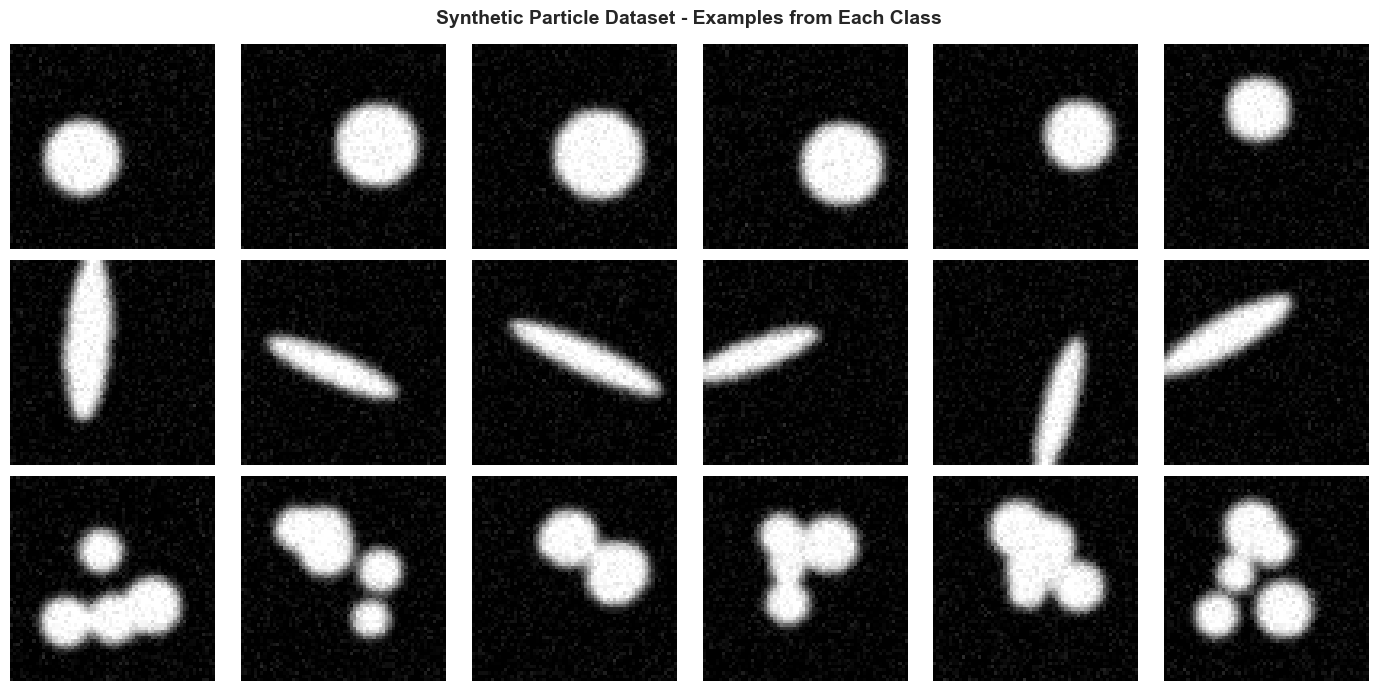

In [4]:
# Visualize sample images from each class
fig, axes = plt.subplots(3, 6, figsize=(14, 7))
class_names = ['Circular\n(Au nanoparticles)', 'Elongated\n(Nanorods)', 'Irregular\n(Aggregates)']

for class_idx in range(3):
    class_images = images[labels == class_idx]
    for i in range(6):
        axes[class_idx, i].imshow(class_images[i], cmap='gray')
        axes[class_idx, i].axis('off')
        if i == 0:
            axes[class_idx, i].set_ylabel(class_names[class_idx], fontsize=11, fontweight='bold')

plt.suptitle('Synthetic Particle Dataset - Examples from Each Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Part 2: Feature Extraction

Extract morphological and texture features from each particle image.

**Feature Categories:**
1. **Morphological:** Area, eccentricity, solidity, aspect ratio
2. **Texture:** GLCM (Gray-Level Co-occurrence Matrix) features
3. **Intensity:** Mean, std, skewness, kurtosis
4. **Shape:** Hu moments (rotation-invariant)

In [5]:
def extract_features(image):
    """
    Extract comprehensive features from a single particle image.
    
    Returns:
        feature_vector: 1D array of features
    """
    features = []
    
    # 1. Binarize for morphological features
    binary = image > filters.threshold_otsu(image)
    binary = morphology.remove_small_objects(binary, min_size=20)
    
    # Label regions
    labeled = measure.label(binary)
    
    if labeled.max() > 0:
        # Get largest region
        props = measure.regionprops(labeled, intensity_image=image)
        main_region = max(props, key=lambda x: x.area)
        
        # Morphological features
        features.append(main_region.area)  # Area
        features.append(main_region.eccentricity)  # Eccentricity (0=circle, 1=line)
        features.append(main_region.solidity)  # Solidity (convex hull ratio)
        features.append(main_region.extent)  # Extent (bbox fill ratio)
        
        # Aspect ratio
        minr, minc, maxr, maxc = main_region.bbox
        aspect_ratio = (maxr - minr) / max((maxc - minc), 1)
        features.append(aspect_ratio)
        
        # Perimeter-based features
        features.append(main_region.perimeter)
        circularity = 4 * np.pi * main_region.area / (main_region.perimeter ** 2 + 1e-6)
        features.append(circularity)
    else:
        # No region found, add zeros
        features.extend([0] * 7)
    
    # 2. Intensity statistics
    features.append(np.mean(image))
    features.append(np.std(image))
    features.append(np.max(image) - np.min(image))  # Dynamic range
    
    # 3. Texture features (simplified GLCM)
    from skimage.feature import graycomatrix, graycoprops
    
    # Normalize to 0-255 for GLCM
    img_uint = (image * 255).astype(np.uint8)
    
    # Compute GLCM
    glcm = graycomatrix(img_uint, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                        levels=256, symmetric=True, normed=True)
    
    # Extract GLCM properties
    contrast = graycoprops(glcm, 'contrast').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    
    features.extend([contrast, homogeneity, energy, correlation])
    
    # 4. Hu moments (shape descriptors)
    moments_hu = measure.moments_hu(binary)
    # Log transform for better scale
    moments_hu_log = -np.sign(moments_hu) * np.log10(np.abs(moments_hu) + 1e-10)
    features.extend(moments_hu_log[:5])  # Use first 5 moments
    
    return np.array(features)

# Extract features for all images
print("Extracting features from all images...")
X = np.array([extract_features(img) for img in images])
print(f"Feature matrix shape: {X.shape}")
print(f"Number of features per image: {X.shape[1]}")

Extracting features from all images...
Feature matrix shape: (300, 19)
Number of features per image: 19


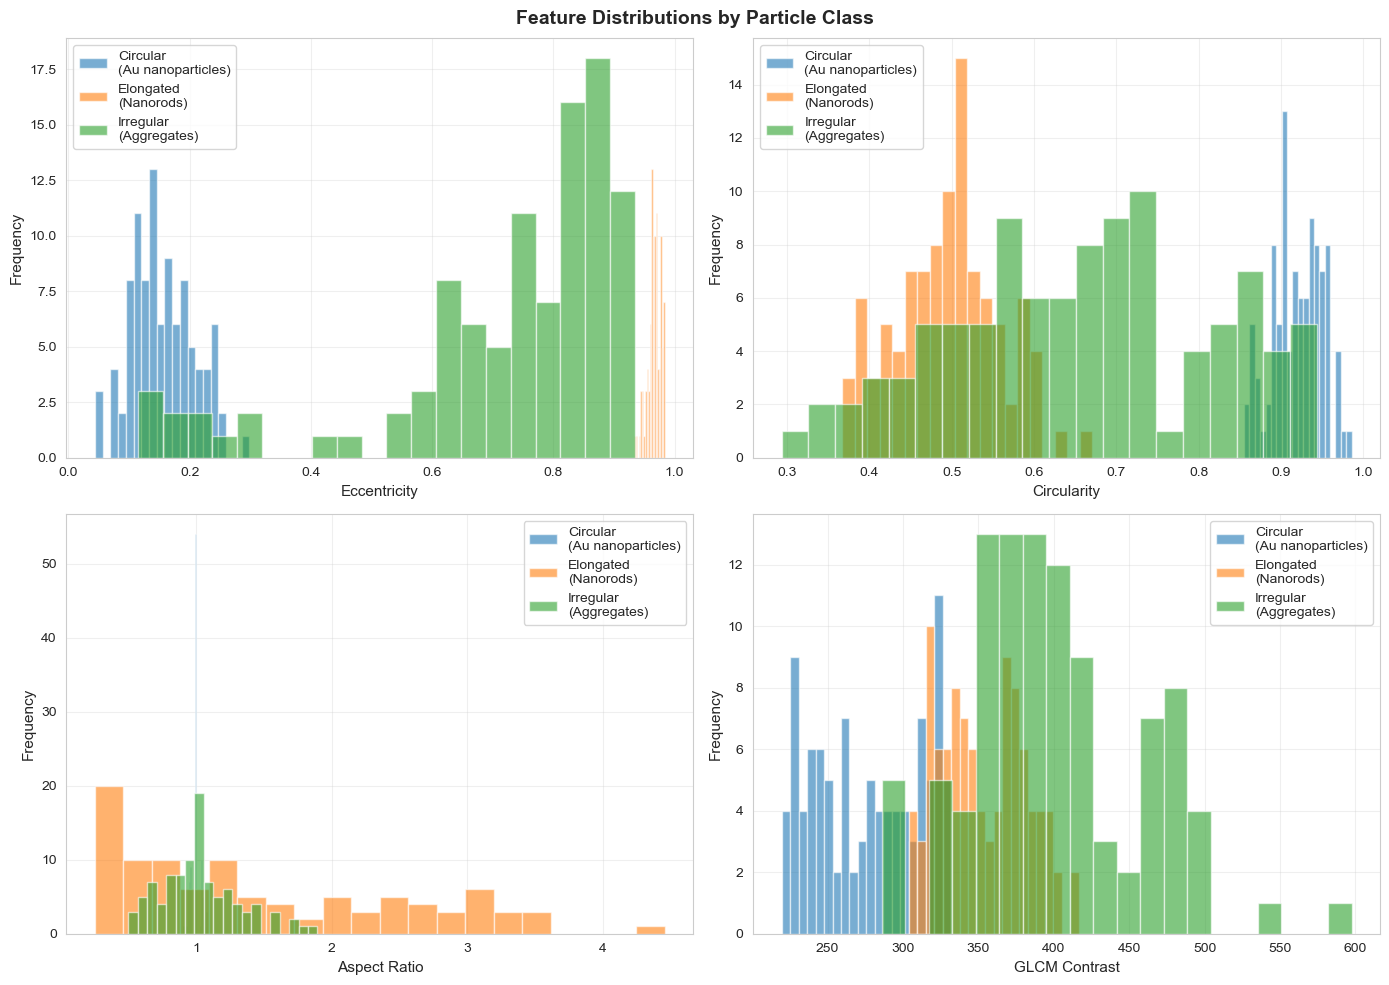


Feature Statistics by Class:
       Eccentricity  Circularity  Aspect Ratio  GLCM Contrast
Class                                                        
0          0.154448     0.919592      0.999442     277.300319
1          0.965989     0.494916      1.471631     352.326022
2          0.721010     0.657876      1.027585     400.043169


In [6]:
# Visualize feature distributions by class
import pandas as pd

# Create DataFrame with features and labels
feature_names = [
    'Area', 'Eccentricity', 'Solidity', 'Extent', 'Aspect Ratio', 
    'Perimeter', 'Circularity', 'Mean Intensity', 'Std Intensity', 'Dynamic Range',
    'GLCM Contrast', 'GLCM Homogeneity', 'GLCM Energy', 'GLCM Correlation',
    'Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5'
]

df = pd.DataFrame(X, columns=feature_names)
df['Class'] = labels

# Plot key features
key_features = ['Eccentricity', 'Circularity', 'Aspect Ratio', 'GLCM Contrast']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, feat in enumerate(key_features):
    for class_idx in range(3):
        data = df[df['Class'] == class_idx][feat]
        axes[i].hist(data, alpha=0.6, bins=20, label=class_names[class_idx])
    
    axes[i].set_xlabel(feat, fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('Feature Distributions by Particle Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nFeature Statistics by Class:")
print(df.groupby('Class')[key_features].mean())

---
## Part 3: Train-Test Split and Preprocessing

Proper data splitting and feature scaling are critical for supervised learning.

In [7]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Testing class distribution: {np.bincount(y_test)}")

# Feature scaling (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled to zero mean and unit variance.")
print(f"Training set mean: {X_train_scaled.mean(axis=0)[:3]} (first 3 features)")
print(f"Training set std: {X_train_scaled.std(axis=0)[:3]} (first 3 features)")

Training set: 240 samples
Testing set: 60 samples
Training class distribution: [80 80 80]
Testing class distribution: [20 20 20]

Features scaled to zero mean and unit variance.
Training set mean: [ 6.84637532e-17  4.03381032e-16 -5.66583817e-15] (first 3 features)
Training set std: [1. 1. 1.] (first 3 features)


---
## Part 4: Model Training and Comparison

Train and compare three classical ML models:
1. **Random Forest** - Ensemble of decision trees
2. **Support Vector Machine (SVM)** - Kernel-based classifier
3. **k-Nearest Neighbors (k-NN)** - Instance-based learning

In [ ]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', C=10, gamma='scale', random_state=42, probability=True),
    'k-NN': KNeighborsClassifier(n_neighbors=5, weights='distance')
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred
    }
    
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"Cross-validation: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'CV Mean': [results[m]['cv_mean'] for m in results],
    'CV Std': [results[m]['cv_std'] for m in results]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

---
## Part 5: Confusion Matrix and Error Analysis

In [ ]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': 'Proportion'})
    
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.suptitle('Confusion Matrices (Normalized)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Part 6: Feature Importance (Random Forest)

Identify which features are most important for classification.

In [ ]:
# Get feature importances from Random Forest
rf_model = results['Random Forest']['model']
feature_importance = rf_model.feature_importances_

# Sort features by importance
indices = np.argsort(feature_importance)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance[indices], align='center')
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\nTop 5 Most Important Features:")
for i in range(5):
    idx = indices[i]
    print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

---
## Part 7: Hyperparameter Tuning (Grid Search)

Optimize model performance using grid search cross-validation.

In [ ]:
# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

print("Performing Grid Search for Random Forest...")
print(f"Testing {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])} combinations")

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"Test accuracy (tuned model): {accuracy_tuned:.3f}")
print(f"Improvement: {accuracy_tuned - results['Random Forest']['accuracy']:.3f}")

---
## Part 8: Prediction on New Data

Apply the trained model to classify unlabeled particle images.

In [ ]:
# Generate new test particles
new_images, true_labels = create_particle_dataset(n_samples=12, img_size=64)

# Extract features
new_features = np.array([extract_features(img) for img in new_images])
new_features_scaled = scaler.transform(new_features)

# Predict using best model
predictions = best_model.predict(new_features_scaled)
prediction_probs = best_model.predict_proba(new_features_scaled)

# Visualize predictions
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.ravel()

for i in range(12):
    axes[i].imshow(new_images[i], cmap='gray')
    axes[i].axis('off')
    
    pred_class = predictions[i]
    confidence = prediction_probs[i][pred_class]
    true_class = true_labels[i]
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_class == true_class else 'red'
    
    title = f"Pred: {class_names[pred_class].split()[0]}\n"
    title += f"Conf: {confidence:.2f}"
    axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')

plt.suptitle('Predictions on New Particle Images\n(Green = Correct, Red = Incorrect)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed results
print("\nDetailed Prediction Results:")
print("="*80)
for i in range(12):
    print(f"Image {i+1}: True={class_names[true_labels[i]].split()[0]:12s} | "
          f"Predicted={class_names[predictions[i]].split()[0]:12s} | "
          f"Confidence={prediction_probs[i][predictions[i]]:.3f} | "
          f"Status={'✓ CORRECT' if predictions[i] == true_labels[i] else '✗ WRONG'}")

accuracy_new = accuracy_score(true_labels, predictions)
print("="*80)
print(f"Accuracy on new data: {accuracy_new:.3f}")

---
## Summary and Key Takeaways

### What We Learned:
1. **Supervised learning workflow**: Label data → Extract features → Train model → Evaluate → Predict
2. **Feature engineering**: Morphological, texture, and shape features are critical for microscopy image classification
3. **Model comparison**: Different algorithms have different strengths:
   - Random Forest: Good interpretability via feature importance
   - SVM: Effective for high-dimensional data with clear margins
   - k-NN: Simple but sensitive to feature scaling
4. **Proper evaluation**: Always use train/test split, cross-validation, and multiple metrics
5. **Hyperparameter tuning**: Grid search can significantly improve performance

### Best Practices for EM Applications:
- **Label quality matters**: Invest time in careful, consistent labeling
- **Feature selection**: Domain knowledge helps choose relevant features
- **Class imbalance**: Use stratified splitting if classes are imbalanced
- **Validation**: Test on independent datasets when possible
- **Interpretability**: Prefer interpretable models (RF) for scientific applications

### Next Steps:
- Apply to real microscopy data (STEM-HAADF, diffraction patterns)
- Explore deep learning approaches (CNNs) that learn features automatically
- Implement active learning for efficient labeling
- Combine with domain knowledge (physics-informed ML)